In [1]:
# %pip install pmdarima statsmodels

In [2]:
# import libary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict Gold Price/XAU_1d_data.csv', sep=';')

df.columns = df.columns.str.lower()

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

print(df.head())
print(f"Null:\n{df.isna().sum()}")


             open   high    low  close  volume
date                                          
2004-06-11  384.0  384.8  382.8  384.1     272
2004-06-14  384.3  385.8  381.8  382.8    1902
2004-06-15  382.8  388.8  381.1  388.6    1951
2004-06-16  387.1  389.8  382.6  383.8    2014
2004-06-17  383.6  389.3  383.0  387.6    1568
Null:
open      0
high      0
low       0
close     0
volume    0
dtype: int64


###  TIME SERIES ANALYSIS – TREND | SEASONALITY | CYCLE | VARIATION

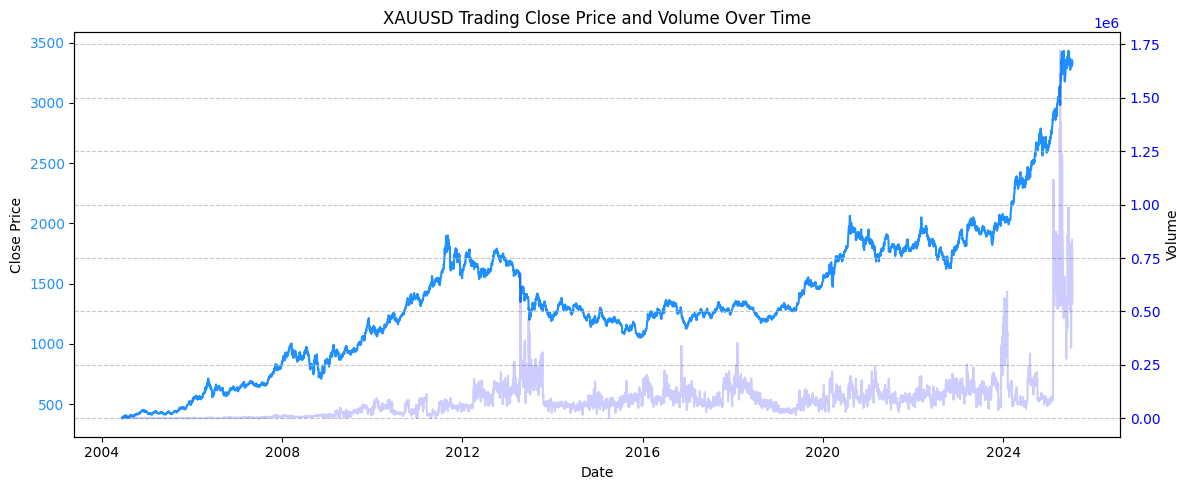

In [5]:
#Close and Volume on two y-axes
plt.figure(figsize=(12,5))

# Create the first y-axis for the close price
ax1 = plt.gca()
ax1.plot(df.index, df['close'], label='close', color='dodgerblue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price')
ax1.tick_params(axis='y', labelcolor='dodgerblue') # Match tick color to line color

# Create the second y-axis for the volume
ax2 = ax1.twinx() # Create a twin Axes sharing the x-axis
ax2.plot(df.index, df['volume'], label='Volume', color='blue', alpha=0.2)
ax2.set_ylabel('Volume')
ax2.tick_params(axis='y', labelcolor='blue') # Match tick color to line color

plt.title('XAUUSD Trading Close Price and Volume Over Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Augmented Dickey-Fuller (ADF) test to formally check this.
- Null Hypothesis ($H_0$): The time series is non-stationary (it has a unit root).
- Alternative Hypothesis ($H_1$​): The time series is stationary.

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """Performs and prints the results of the ADF test."""
    print("--- Results of Augmented Dickey-Fuller Test ---")
    result = adfuller(series.dropna())

    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")

    if result[1] <= 0.05:
        print("Conclusion: Reject H0. The series is likely stationary.")
    else:
        print("Conclusion: Fail to Reject H0. The series is non-stationary.")

# Run the test on the 'close' price
adf_test(df['close'])

--- Results of Augmented Dickey-Fuller Test ---
ADF Statistic: 1.2942
p-value: 0.9966
Conclusion: Fail to Reject H0. The series is non-stationary.


<Figure size 1400x1000 with 0 Axes>

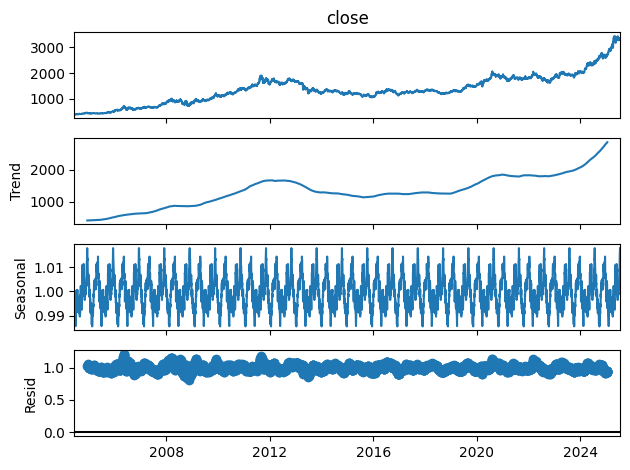

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the 'close' price series (using the Multiplicative model)
# We assume a periodicity of 252 (number of trading days in a year)
decomposition = seasonal_decompose(df['close'], model='multiplicative', period=252)

# Plot the decomposed components
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

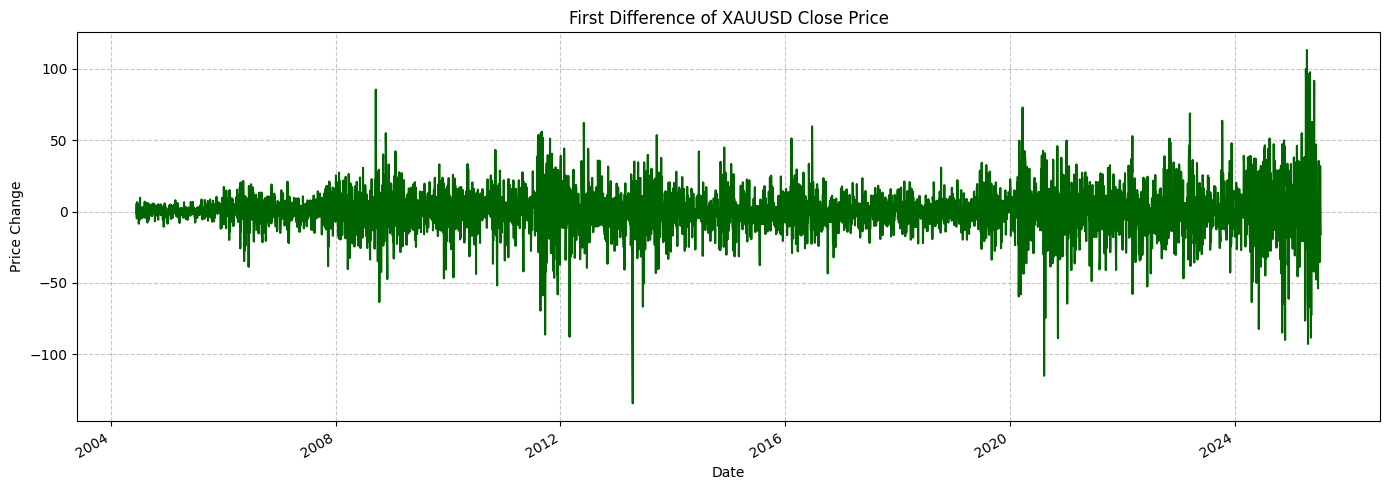


--- Testing Stationarity of the DIFFERENCED Series ---
--- Results of Augmented Dickey-Fuller Test ---
ADF Statistic: -73.5702
p-value: 0.0000
Conclusion: Reject H0. The series is likely stationary.


In [8]:
# Calculate the first difference of the close price
df['close_diff'] = df['close'].diff(periods=1)

# Plot the differenced series
plt.figure(figsize=(14, 5))
df['close_diff'].plot(title='First Difference of XAUUSD Close Price',
                      color='darkgreen',
                      linewidth=1.5)
plt.xlabel("Date")
plt.ylabel("Price Change")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Test the differenced series for stationarity
print("\n--- Testing Stationarity of the DIFFERENCED Series ---")
adf_test(df['close_diff'])

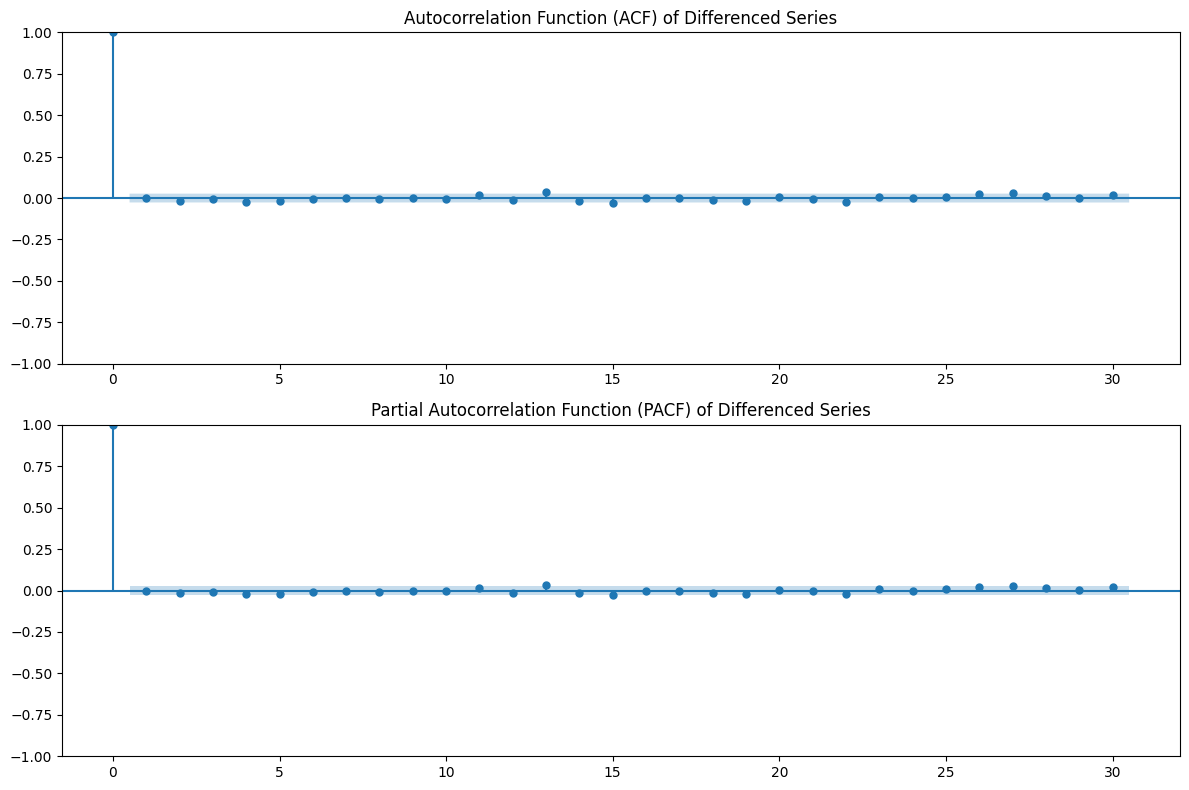

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure you use the stationary series (the first difference)
stationary_series = df['close_diff'].dropna()

# Create plots for ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Autocorrelation Function (ACF) plot
plot_acf(stationary_series, lags=30, ax=axes[0], title='Autocorrelation Function (ACF) of Differenced Series')

# Partial Autocorrelation Function (PACF) plot
plot_pacf(stationary_series, lags=30, ax=axes[1], title='Partial Autocorrelation Function (PACF) of Differenced Series')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 5418
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -22458.646
Date:                Sun, 26 Oct 2025   AIC                          44923.292
Time:                        15:02:26   BIC                          44943.084
Sample:                             0   HQIC                         44930.200
                               - 5418                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8508      0.100      8.548      0.000       0.656       1.046
ma.L1         -0.8622      0.096     -9.003      0.000      -1.050      -0.674
sigma2       233.6990      2.068    112.980      0.0

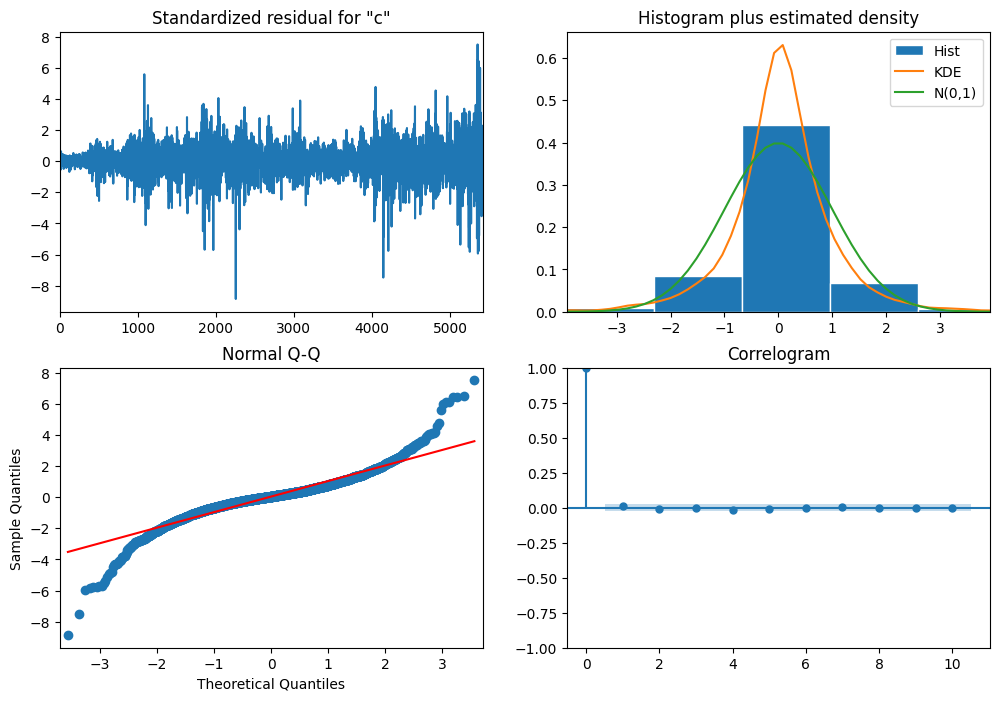

In [10]:
# ASSUMING you found p=1 and q=1 from the plots, for example:
p, d, q = 1, 1, 1

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['close'], order=(p, d, q))
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(12, 8))
plt.show()

In [11]:
# and then apply backtesting day trade > the model predict the prive of the next day would Bull/ Bear then based on that prdict day. set a long/ short based on the predict.

## Prepare data

### Subtask:
Create training and testing datasets for the LSTM model.


**Reasoning**:
Split the dataframe into training and testing sets based on an 80/20 split and display their shapes.



In [12]:
# Apply data processing steps before splitting

train_size = int(len(df) * 0.8)
train_data, test_data = df[0:train_size], df[train_size:]

print(f"Shape of training data: {train_data.shape}")
print(f"Shape of testing data: {test_data.shape}")

Shape of training data: (4334, 6)
Shape of testing data: (1084, 6)


## Build and train lstm model

### Subtask:
Define, compile, and train the LSTM model using the training data.


**Reasoning**:
Import necessary libraries for building and training an LSTM model.



In [15]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [16]:
# Select the 'close' price for training
train_close = train_data['close'].values.reshape(-1, 1)

# Scale the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_close)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Define sequence length (number of past days to consider)
seq_length = 60 # This can be tuned

X_train, y_train = create_sequences(scaled_train_data, seq_length)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (4274, 60, 1)
Shape of y_train: (4274,)


**Reasoning**:
Define and compile the LSTM model architecture.



In [17]:
# Define the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32)

# Store the trained model (optional, but good practice)
model.save('lstm_model.h5')

Epoch 1/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 0.0232
Epoch 2/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0022
Epoch 3/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0016
Epoch 4/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0015
Epoch 5/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0012
Epoch 6/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 9.7964e-04
Epoch 7/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 9.5637e-04
Epoch 8/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 7.9154e-04
Epoch 9/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - loss: 7.5987e-04
Epoch 10/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 6.8574e-04
Epoch 11/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 6.1308e-04
Epoch 12/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 6.2652e-04
Epoch 13/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 6.2829e-04
Epoch 14/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 6.1683e

## Make Predictions



In [19]:
# Prepare test data
# Select the 'close' price for testing
test_close = test_data['close'].values.reshape(-1, 1)

# Scale the test data using the *same* scaler fitted on the training data
scaled_test_data = scaler.transform(test_close)

# Create sequences for LSTM
# We need to include some data from the end of the training set to create the first test sequence
# A common approach is to combine the end of the training data with the test data
combined_data = scaled_train_data[len(scaled_train_data) - seq_length:]
combined_data = np.concatenate((combined_data, scaled_test_data))

X_test, y_test = create_sequences(combined_data, seq_length)

# Reshape input to be [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_test: (1084, 60, 1)
Shape of y_test: (1084,)


**Reasoning**:
Use the trained LSTM model to generate price predictions for the test dataset.

In [35]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to get the actual price scale
predictions = scaler.inverse_transform(predictions)

# Inverse transform the actual test values for comparison
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Test Predictions (array):")
print(predictions)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Test Predictions (array):
[[1786.256 ]
 [1787.6096]
 [1793.4535]
 ...
 [3295.1858]
 [3300.413 ]
 [3305.3667]]


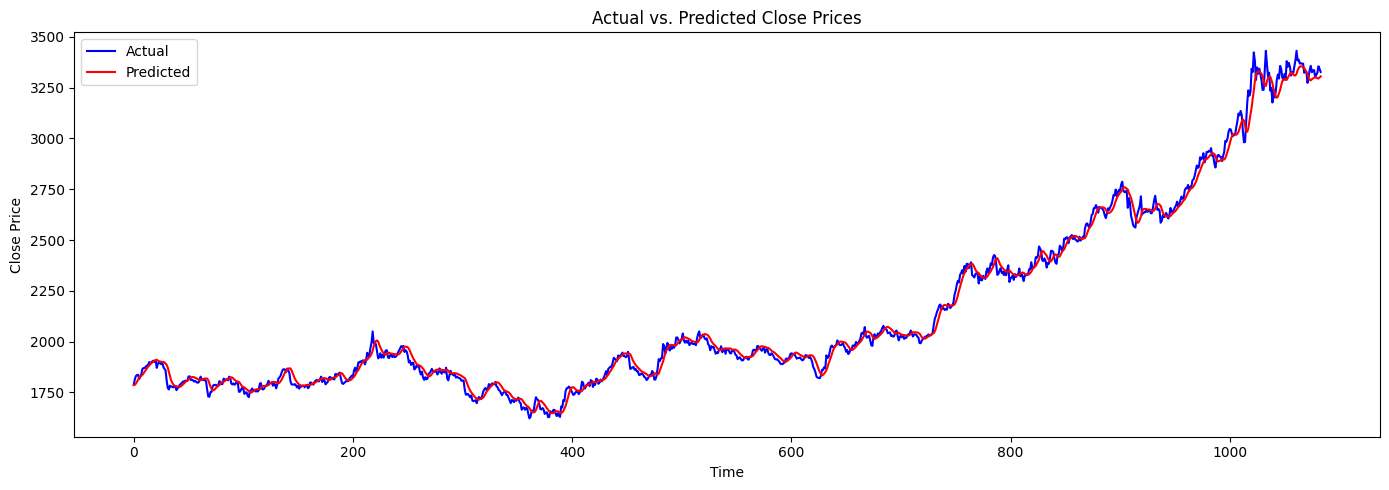

In [49]:
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

Based on the time series analysis:
* The XAUUSD close price series was found to be non-stationary, as indicated by the Augmented Dickey-Fuller (ADF) test (p-value > 0.05).
* Differencing the series once made it stationary (ADF test p-value < 0.05).
* The ACF and PACF plots of the differenced series helped in identifying potential orders for ARIMA models (though an LSTM was used in this case).

The LSTM model was built and trained to predict the close price.
* The model achieved a Mean Squared Error (MSE) of {mse:.4f} and a Root Mean Squared Error (RMSE) of {rmse:.4f} on the test data.
* The plot of actual vs. predicted values shows the model's ability to capture the general trend of the price movements, although there are deviations between the predicted and actual values.

Further steps could involve:
* Hyperparameter tuning for the LSTM model to potentially improve performance.
* Exploring other time series forecasting models (e.g., ARIMA, Prophet, other deep learning architectures).
* Incorporating additional features (e.g., other technical indicators, news sentiment) to potentially enhance prediction accuracy.

## Prepare Test Data for Backtesting

### Subtask:
Ensure the test data is in a suitable format for backtesting, potentially including the previous day's close price to determine the direction of the predicted move.

**Reasoning**:
Prepare the test data by ensuring it includes the actual closing prices and the model's predictions, and potentially adding the previous day's closing price to determine the predicted direction.

In [47]:
# Ensure 'predictions' and 'y_test_actual' are available from previous steps
# 'predictions' contains the model's predicted closing prices for the test set
# 'y_test_actual' contains the actual closing prices for the test set

# Create a DataFrame for backtesting
# The number of predictions is len(test_data) - seq_length
backtest_index = test_data.index[seq_length:]

backtest_df = pd.DataFrame({
    'Actual_Close': y_test_actual.flatten(),
    'Predicted_Close': predictions.flatten()
}, index=backtest_index) # Use the correct index for the test set predictions


# Add the previous day's actual close price to determine the predicted direction
# Get the last training close price
last_train_close = df['close'].iloc[train_size - 1]

# Get the shifted 'Actual_Close' for the test period (excluding the first value which is NaN)
shifted_test_close = backtest_df['Actual_Close'].shift(1).iloc[1:]

# Combine the last training close price with the shifted test close prices
previous_day_close_values = np.insert(shifted_test_close.values, 0, last_train_close)

# Assign the combined values to the 'Previous_Close' column
backtest_df['Previous_Close'] = previous_day_close_values


print(backtest_df.head())

ValueError: Length of values (1084) does not match length of index (1024)